In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

Carregar os dados:

In [23]:
file_path = 'SemOutlierSemNAN.csv'
data = pd.read_csv(file_path)

Separar características, alvo e dividir os conjuntos em teste e treinamento


In [25]:
from imblearn.under_sampling import RandomUnderSampler
X = data.drop('Q03001', axis=1)  
y = data['Q03001']  

# Passo 2: Separar os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 3: Aplicar undersampling aos dados de treinamento para balancear, reduzindo amostras da classe majoritária.
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

Configurar e executar o Random Search

In [26]:
param_distributions = {
    'n_estimators': np.arange(50, 200, 10),
    'max_features': ['sqrt', 'log2'],  # corrigido para valores válidos
    'max_depth': np.arange(10, 50, 5),
    'min_samples_split': np.arange(2, 10, 1),
    'min_samples_leaf': np.arange(1, 10, 1),
    'bootstrap': [True, False]
}

# Configurar e executar o Random Search
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, error_score='raise')
random_search.fit(X_train_balanced, y_train_balanced)

# Melhor modelo
best_rf = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Treinar o Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators=3, random_state=42)  # número reduzido de árvores
rf.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(n_estimators=3, random_state=42)

*Avaliar o modelo*

Métricas de Avaliação

In [28]:
from sklearn.metrics import classification_report


y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.23      0.58      0.33       661
         2.0       0.82      0.50      0.62      2544

    accuracy                           0.52      3205
   macro avg       0.53      0.54      0.48      3205
weighted avg       0.70      0.52      0.56      3205



Plotar Árvores

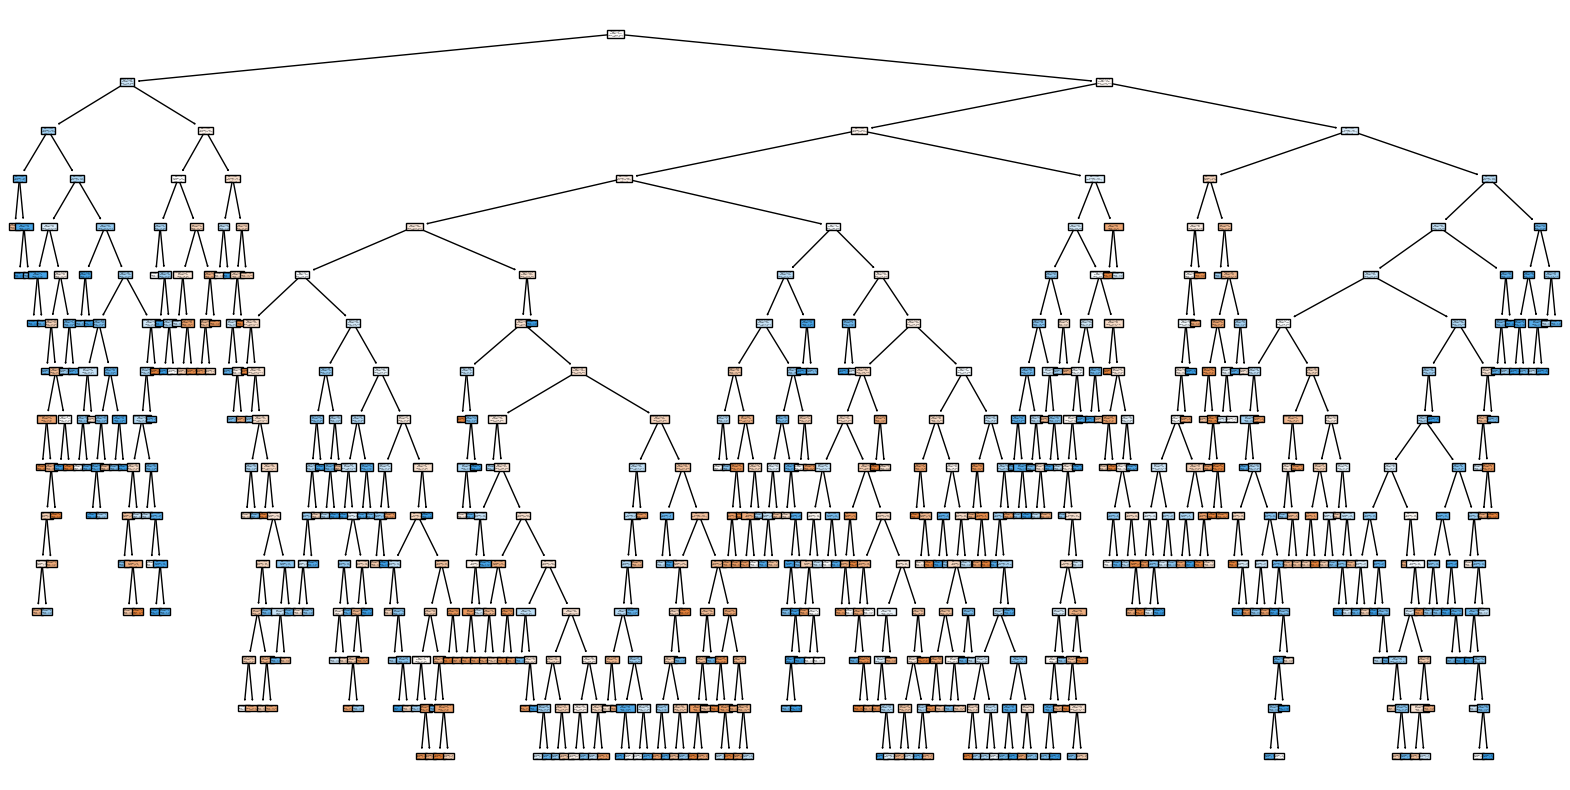

In [33]:
from sklearn.tree import plot_tree

# Converter os nomes das classes para strings
class_names = [str(c) for c in np.unique(y)]

plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], filled=True, feature_names=X.columns, class_names=class_names)
plt.show()


Plotar matriz de confusão

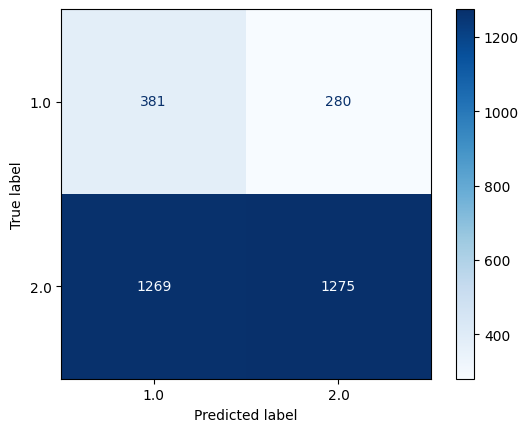

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()